In [17]:
from deep_sort_realtime.deepsort_tracker import DeepSort
import numpy as np 
import supervision as sv 
import os 
import ultralytics
from ultralytics import YOLO 
from IPython import display

In [18]:
display.clear_output()

ultralytics.checks()

Ultralytics 8.3.19  Python-3.10.16 torch-2.7.0+cpu CPU (13th Gen Intel Core(TM) i7-13700H)
Setup complete  (20 CPUs, 13.7 GB RAM, 138.5/221.0 GB disk)


### Load pre-trained YOLOv10 model

In [15]:
model = YOLO("yolov10x.pt")

In [19]:
CLASS_NAMES_DICT = model.model.names 

SELECTED_CLASS_NAMES = ['car', 'motorcycle', 'bus', 'truck']

SELECTED_CLASS_IDS = [ 
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name]
    for class_name in SELECTED_CLASS_NAMES
]

In [7]:
HOME = os.getcwd()
SOURCE_VIDEO_PATH = f"{HOME}/vehicle-counting.mp4"
TARGET_VIDEO_PATH = f"{HOME}/result_DeepSORT.mp4"

In [8]:
LINE_START = sv.Point(0 + 50, 1500)
LINE_END = sv.Point(3840 - 50, 1500)

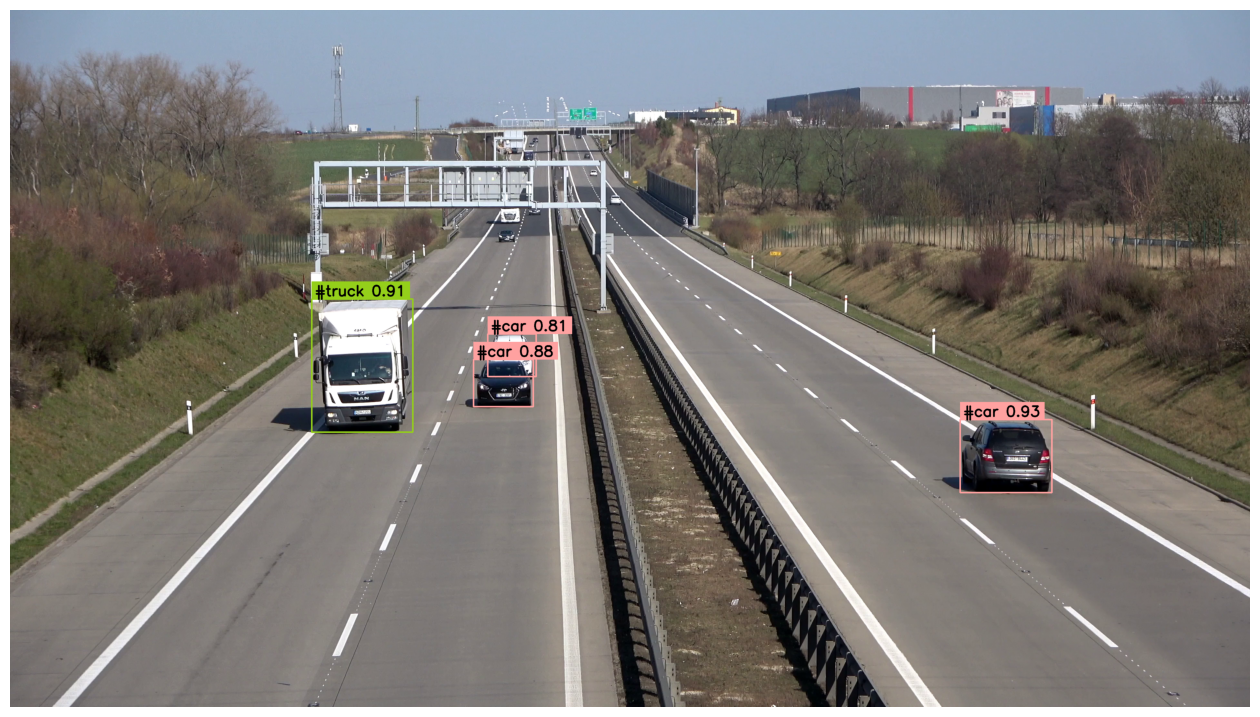

In [26]:
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(
    text_thickness=4, 
    text_scale=1.5, 
    text_color=sv.Color.BLACK 
)

iterator = iter(generator)
frame = next(iterator)

results = model(frame, verbose=False)[0]

detections = sv.Detections.from_ultralytics(results)

detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

labels = [ 
    f"#{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}" 
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate( 
    scene=annotated_frame,
    detections=detections
)

annotated_frame = label_annotator.annotate( 
    scene=annotated_frame, 
    detections=detections, 
    labels=labels
)

%matplotlib inline 
sv.plot_image(annotated_frame, (16, 16))

In [27]:
deep_sort_tracker = DeepSort(
    max_age=30, 
    n_init=3, 
    max_cosine_distance=0.2
)
box_annotator = sv.BoxAnnotator(thickness=4)

label_annotator = sv.LabelAnnotator(
    text_thickness=2,
    text_scale=1.5,
    text_color=sv.Color.BLACK 
)

trace_annotator = sv.TraceAnnotator(
    thickness=4, 
    trace_length=50
)

line_zone_annotator = sv.LineZoneAnnotator(
    thickness=4, 
    text_thickness=4, 
    text_scale=2
)

line_zone = sv.LineZone(
    start=LINE_START,
    end=LINE_END
)


In [28]:
def callback(frame: np.ndarray, index: int):
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

    ds_detections = []
    for bbox, conf, class_id in zip(detections.xyxy, detections.confidence, detections.class_id):
        class_name = CLASS_NAMES_DICT.get(class_id, "Unknown")
        left, top, xmax, ymax = bbox 
        width, height = xmax - left, ymax - top 
        ds_detections.append((
            [left, top, width, height], 
            float(conf), 
            class_name
        ))

    tracks = deep_sort_tracker.update_tracks(
        ds_detections,
        frame=frame
    )

    tracked_bboxes = []
    tracked_confidences = []
    tracked_class_ids = []
    tracked_ids = []

    for track in tracks:
        if not track.is_confirmed(): 
            continue 

        track_id = track.track_id 
        bbox = track.to_ltrb()
        conf = getattr(track, 'def_conf', 1.0)

        class_name = track.get_det_class() or "Unknown"

        class_id = {value: key for key, value in CLASS_NAMES_DICT.items()}.get(class_name, None)
        if class_id is None:
            class_id = 0

        tracked_bboxes.append(bbox)
        tracked_confidences.append(conf)
        tracked_class_ids.append(class_id)
        tracked_ids.append(track_id)

    
    if len(tracked_bboxes) > 0:
        tracked_detections = sv.Detections(
            xyxy=np.array(tracked_bboxes, dtype=np.float32).reshape(-1, 4), 
            confidence=np.array(tracked_confidences, dtype=np.float32), 
            class_id = np.array(tracked_class_ids, dtype=np.int32), 
            tracker_id = np.array(tracked_ids, dtype=np.int32)
        )
    else:
        tracked_detections = sv.Detections(
            xyxy=np.zeros((0, 4), dtype=np.float32), 
            confidence=np.array([], dtype=np.float32), 
            class_id = np.array([], dtype=np.int32), 
            tracker_id = np.array([], dtype=np.int32),
        )

    labels = [ 
        f"{tracker_id} {CLASS_NAMES_DICT.get(class_id, 'Unknown')}"
        for tracker_id, class_id in zip(tracked_ids, tracked_class_ids)
    ]

    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame,
        detections=tracked_detections
    )

    annotated_frame = box_annotator.annotate(
        scene=annotated_frame, 
        detections=tracked_detections
    )

    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, 
        detections=tracked_detections,
        labels=labels
    )

    line_zone.trigger(tracked_detections)

    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)

In [29]:
import subprocess
import imageio_ffmpeg as ffmpeg

input_file = "result_DeepSORT.mp4"
output_file = "output_video_DeepSort.mp4"

ffmpeg_path = ffmpeg.get_ffmpeg_exe()

cmd = [
    ffmpeg_path,
    "-i", input_file,
    "-c:v", "libx264",
    "-preset", "fast",
    "-crf", "23",
    "-c:a", "aac",
    output_file
]

subprocess.run(cmd, check=True)

CompletedProcess(args=['c:\\Users\\AMIN\\anaconda3\\envs\\cvp\\lib\\site-packages\\imageio_ffmpeg\\binaries\\ffmpeg-win-x86_64-v7.1.exe', '-i', 'result_DeepSORT.mp4', '-c:v', 'libx264', '-preset', 'fast', '-crf', '23', '-c:a', 'aac', 'output_video_DeepSort.mp4'], returncode=0)

In [30]:
from IPython.display import Video, display

video = Video("output_video_DeepSORT.mp4", width=800)
display(video)